### Part 1 - Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd

# Load JSON
df = pd.read_json("logins.json")

# Convert to datetime
df['login_time'] = pd.to_datetime(df['login_time'])

# Set as index (for resampling)
df.set_index('login_time', inplace=True)


In [4]:
# Count logins in 15-min intervals
# Series where each value is the count of logins in that 15-min interval
df_15min = df.resample('15T').size()

print(df_15min.head())
print("Total 15-min intervals:", df_15min.shape[0])
print("Nonzero intervals:", (df_15min > 0).sum())


login_time
1970-01-01 20:00:00    2
1970-01-01 20:15:00    6
1970-01-01 20:30:00    9
1970-01-01 20:45:00    7
1970-01-01 21:00:00    1
Freq: 15T, dtype: int64
Total 15-min intervals: 9788
Nonzero intervals: 9381


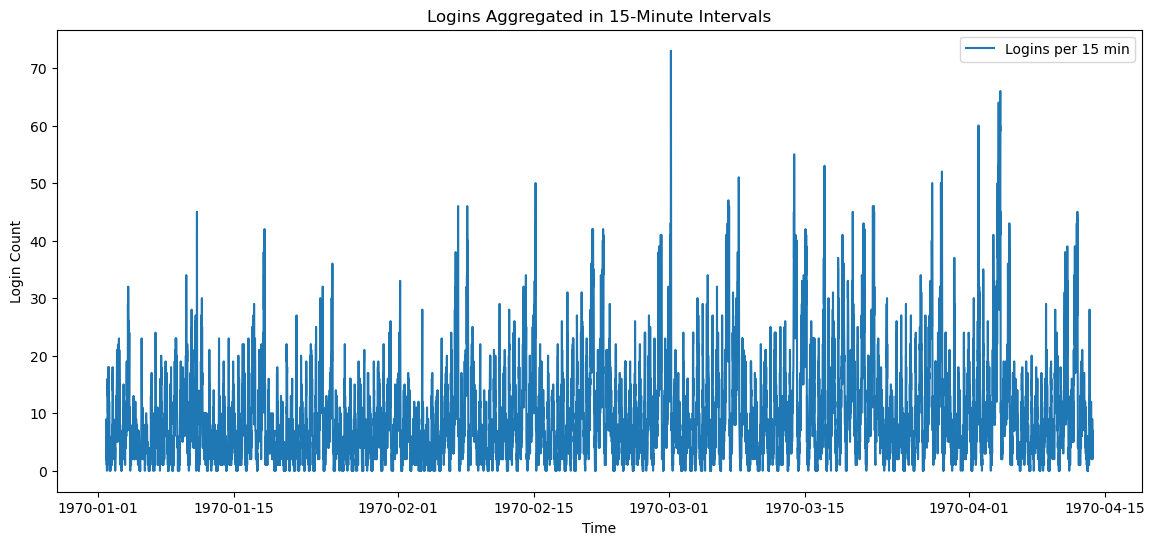

In [6]:
# Visualise

# logins per 15 min interval

import matplotlib.pyplot as plt

if df_15min.shape[0] == 0:
    raise ValueError("No data to plot: df_15min is empty.")

plt.figure(figsize=(14, 6))
plt.plot(df_15min.index, df_15min.values, label="Logins per 15 min")
plt.title("Logins Aggregated in 15-Minute Intervals")
plt.xlabel("Time")
plt.ylabel("Login Count")
plt.legend()
plt.show()


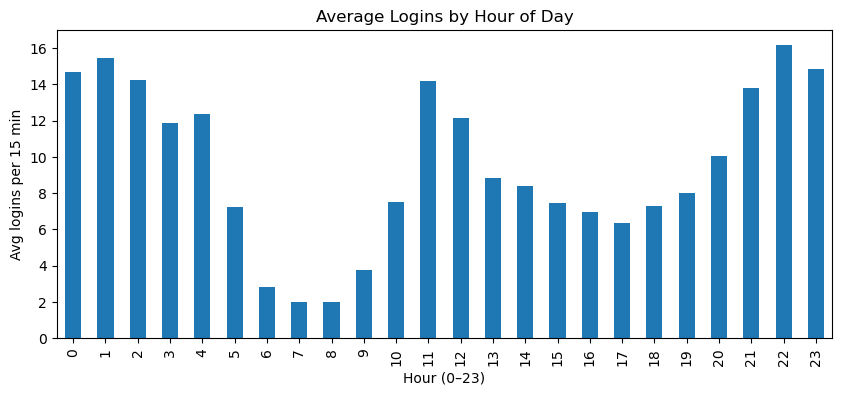

In [7]:
# Daily cycle: Average by hour of the day

hourly_avg = df_15min.groupby(df_15min.index.hour).mean()

plt.figure(figsize=(10, 4))
hourly_avg.plot(kind='bar', legend=False)
plt.title("Average Logins by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Avg logins per 15 min")
plt.show()


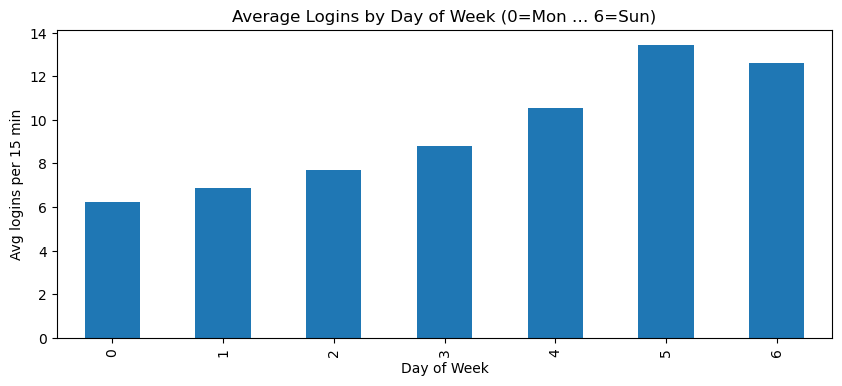

In [8]:
# weekly cycle: Average by hour of the week

dow_avg = df_15min.groupby(df_15min.index.dayofweek).mean()

plt.figure(figsize=(10, 4))
dow_avg.plot(kind='bar', legend=False)
plt.title("Average Logins by Day of Week (0=Mon … 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Avg logins per 15 min")
plt.show()


In [9]:
# quality check

print("Any negative counts?", (df_15min < 0).any())
print("Share of zero-activity intervals:", (df_15min == 0).mean())

# Check for long gaps (e.g., > 2 hours with no logins)
gap_mask = df_15min == 0
streak = (gap_mask != gap_mask.shift()).cumsum()
zero_runs = gap_mask.groupby(streak).sum()
long_zero_runs = zero_runs[zero_runs >= 8]  # 8 * 15min = 2 hours
print("Zero-activity runs >= 2 hours:\n", long_zero_runs)


Any negative counts? False
Share of zero-activity intervals: 0.04158152840212505
Zero-activity runs >= 2 hours:
 Series([], dtype: int64)


### Interpretation of Results

Time series: Logins show frequent spikes, reaching 60+ per 15 min, with consistent activity and few zero-activity intervals (~4%).

Daily cycle: Activity peaks late at night (11 PM–1 AM) and is lowest early morning (6–9 AM), showing strong night-time usage.

Weekly cycle: Logins increase through the week, with the highest activity on weekends (especially Saturday).

Data quality: No major gaps or anomalies; data is reliable for analysis.

### Part 2 - Experiment and Metrics Design

#### Key Measure of Success
The most important measure of success for this experiment is the proportion of drivers who actively serve both cities (cross-city participation rate). This metric directly captures the intended effect of reimbursing toll costs — encouraging drivers to operate across Gotham and Metropolis rather than remaining exclusive to one city. Secondary metrics such as the average number of trips per driver across both cities, driver earnings, and rider wait times can provide additional insight into the broader operational impact of the reimbursement policy.

#### Experiment Design
##### 1. Implementation
The experiment will be structured as a randomized controlled trial (A/B test). Drivers will be randomly assigned into two groups:
(a) Treatment group: receives full toll reimbursement.
(b) Control group: continues under current conditions, paying tolls as usual.
Randomization ensures balance across groups in terms of driver experience, typical activity level, and signup cohort. The test should run for several weeks to capture both weekday and weekend travel patterns, since demand profiles differ significantly between the two cities.

##### 2. Statistical Testing
To assess the impact, the cross-city participation rate will be compared between treatment and control groups using a two-proportion z-test (or chi-square test). For continuous outcomes, such as trips per driver and earnings, a two-sample t-test (or Mann–Whitney U test if normality assumptions are violated) will be applied. A significance threshold of α = 0.05 will be used.

##### 3. Interpretation and Recommendations
If the treatment group demonstrates a statistically significant increase in cross-city participation compared to the control group, it would indicate that toll reimbursement is effective. Additional improvements in trips per driver and reduced rider wait times would further strengthen the case for rolling out the policy more broadly. However, results should be interpreted with caution: external factors such as seasonal demand shifts or temporary behavior changes during the test period could influence outcomes. To mitigate this, the experiment should run long enough to capture stable demand cycles, and follow-up monitoring should assess whether the effect persists after the initial rollout.

### Part 3 - Predictive Modelling

In [23]:
# Convert .json to .csv

import pandas as pd

df = pd.read_json("ultimate_data_challenge.json")
df.to_csv("ultimate_data_challenge.csv", index=False)

In [24]:
# Load dataset
df = pd.read_csv("ultimate_data_challenge.csv")

In [25]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

In [26]:
df.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [28]:
#drop rows with no phone information, since we cannot infer that without building a predictive model
df = df.drop(df[df.phone.isna()==True].index,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [31]:
# Prepare data and Retention label

# Convert to datetime
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])

# Define snapshot date
snapshot_date = df["last_trip_date"].max()

# Retention = active in last 30 days of snapshot
df["retained"] = (df["last_trip_date"] >= snapshot_date - pd.Timedelta(days=30)).astype(int)

print("Snapshot date:", snapshot_date)
print("Retention fraction:", df["retained"].mean())


Snapshot date: 2014-07-01 00:00:00
Retention fraction: 0.37640109668575117


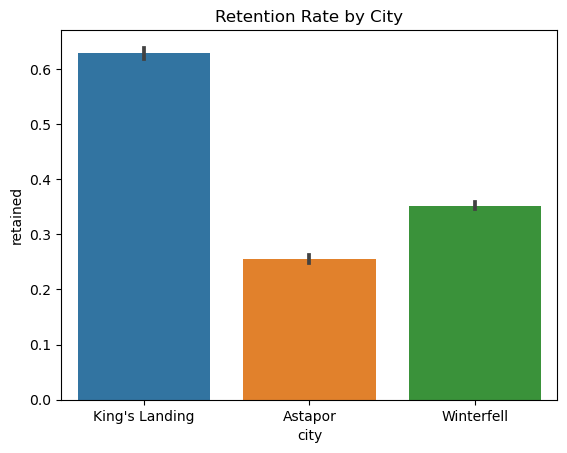

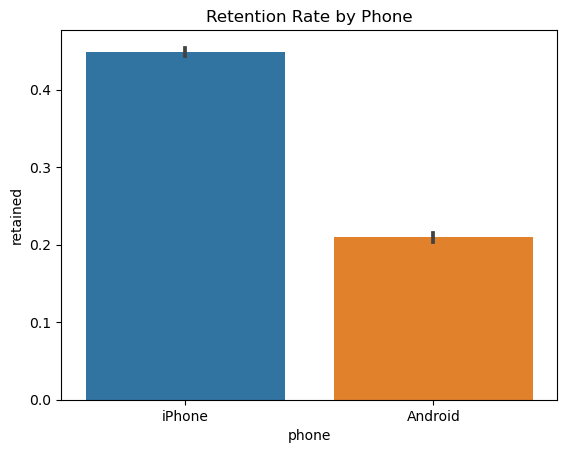

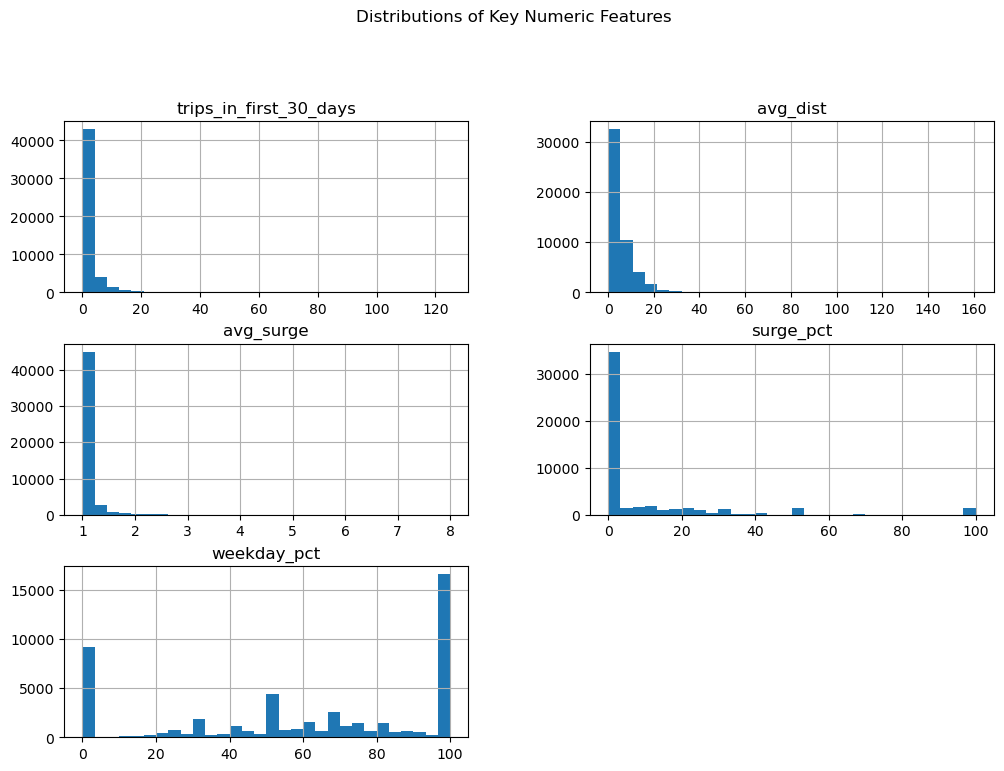

In [32]:
# EDA
# Fill missing values for plotting
eda_df = df.copy()
eda_df["avg_rating_of_driver"] = eda_df["avg_rating_of_driver"].fillna(eda_df["avg_rating_of_driver"].median())
eda_df["avg_rating_by_driver"] = eda_df["avg_rating_by_driver"].fillna(eda_df["avg_rating_by_driver"].median())
eda_df["phone"] = eda_df["phone"].fillna("Unknown")

# Retention by city
sns.barplot(data=eda_df, x="city", y="retained", estimator=lambda x: sum(x)/len(x))
plt.title("Retention Rate by City")
plt.show()

# Retention by phone
sns.barplot(data=eda_df, x="phone", y="retained", estimator=lambda x: sum(x)/len(x))
plt.title("Retention Rate by Phone")
plt.show()

# Histograms of numeric features
numeric_cols = ["trips_in_first_30_days","avg_dist","avg_surge","surge_pct","weekday_pct"]
eda_df[numeric_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Distributions of Key Numeric Features", y=1.02)
plt.show()


In [33]:
# Train/Test Split and Preprocessing

features_cat = ["city", "phone", "ultimate_black_user"]
features_num = [
    "avg_dist","avg_rating_by_driver","avg_rating_of_driver",
    "surge_pct","avg_surge","trips_in_first_30_days","weekday_pct"
]
target = "retained"

X = df[features_cat + features_num].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessor
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat),
    ("num", SimpleImputer(strategy="median"), features_num)
], remainder="drop")


In [34]:
# Logistic Regression Model

logit = Pipeline([
    ("prep", pre),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced"))
])
logit.fit(X_train, y_train)

p_test_logit = logit.predict_proba(X_test)[:,1]

print("Logistic ROC-AUC:", roc_auc_score(y_test, p_test_logit))
print("Logistic PR-AUC:", average_precision_score(y_test, p_test_logit))


Logistic ROC-AUC: 0.7585640546478184
Logistic PR-AUC: 0.656538361244288


C:\Users\Harmandeep Kaur\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
# Random Forest Model

rf = Pipeline([
    ("prep", pre),
    ("clf", RandomForestClassifier(
        n_estimators=300, min_samples_leaf=2,
        class_weight="balanced_subsample", random_state=42
    ))
])
rf.fit(X_train, y_train)

p_test_rf = rf.predict_proba(X_test)[:,1]

print("RandomForest ROC-AUC:", roc_auc_score(y_test, p_test_rf))
print("RandomForest PR-AUC:", average_precision_score(y_test, p_test_rf))


RandomForest ROC-AUC: 0.8373181746996333
RandomForest PR-AUC: 0.7680169217704895


                   feature  importance
7                 avg_dist    0.227925
13             weekday_pct    0.140389
8     avg_rating_by_driver    0.127027
10               surge_pct    0.087530
12  trips_in_first_30_days    0.081793
9     avg_rating_of_driver    0.072177
11               avg_surge    0.069019
1      city_King's Landing    0.063786
3            phone_Android    0.027401
4             phone_iPhone    0.026398


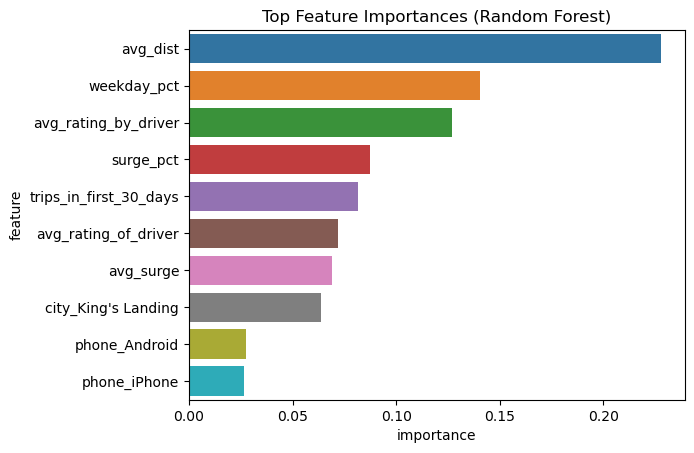

In [36]:
# Feature importance(Random Forest)

# Get feature names after one-hot encoding
rf_model = rf.named_steps["clf"]
ohe = rf.named_steps["prep"].named_transformers_["cat"]
feature_names_cat = ohe.get_feature_names_out(features_cat)
feature_names = np.concatenate([feature_names_cat, features_num])

# Sort top features
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"feature": feature_names, "importance": importances})
feat_imp = feat_imp.sort_values("importance", ascending=False).head(10)

print(feat_imp)

# Plot
sns.barplot(data=feat_imp, x="importance", y="feature")
plt.title("Top Feature Importances (Random Forest)")
plt.show()


### Interpretation of Part 3

#### 1. Retention Overview
(a) The overall retention rate is about 37.6%, meaning fewer than 4 in 10 users were still active in the last 30 days.
(b) Retention varies strongly by city: King’s Landing shows the highest retention (63%), while Astapor has the lowest (25%).
(c) By phone type, iPhone users retain better (45%) compared to Android (21%).

#### 2. Model Performance
Logistic Regression achieved a ROC-AUC of 0.76 and PR-AUC of 0.66, showing moderate ability to separate retained vs. churned users.
Random Forest performed substantially better, with ROC-AUC of 0.84 and PR-AUC of 0.77, indicating strong predictive power.
This suggests that retention behavior is non-linear and benefits from interaction effects captured by Random Forest.

#### 3. Feature Importance (Random Forest)
The top drivers of retention are:
1. Average trip distance – users who take longer trips are more likely to stay active.
2. Weekday activity % – frequent weekday riders show stronger loyalty than weekend-only users.
3. Driver ratings (by & of driver) – higher satisfaction from both sides correlates with retention.
4. Surge-related behavior – both surge % and average surge are important signals of tolerance to pricing conditions.
5. Trips in first 30 days – early engagement strongly predicts whether users stick around.
6. City & phone type – location and device ecosystem also play a role but are secondary to behavioral factors.

#### 4. Business Implications
Focus on Astapor: Its low retention suggests service issues (e.g., fewer drivers, pricing, or local competition).
Boost early engagement: Encourage more trips in the first month via onboarding promotions or loyalty credits.
Improve Android experience: Since iPhone users retain much better, Android user churn could be linked to app quality or UX gaps.
Encourage weekday trips: Weekday ride campaigns could help convert weekend-only riders into regular users.
Maintain driver quality: Ratings on both sides matter; investing in driver support and user experience can drive retention.